# Deep Dream - français
Original version // version originale:  https://www.tensorflow.org/tutorials/generative/deepdream

## Licence

In [5]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

Ce tutorial présente une implémentation minimale de DeepDream, tel que décrit par Alexander Mordvintsev sur son blog.

DeepDream est une expérience visant à visualiser les patrons ou motifs appris par un réseau de neurones. De façon similaire à l'enfant qui regarde les nuages tout en essayant d'interpréter des formes aléatoires, DeepDream sur-interprète et met de l'avant les motifs qu'il voit dans les images.

Pour ce faire, il transmet une image au travers du réseau, puis calcule le gradient de l'image en rapport aux activations d'une couche spécifique. Par la suite, l'image est modifiée de façon à augmenter la valeur prise par ces activations, de ce fait même améliorant les motifs et patrons vus par le réseau et donnant une impression de rêve. Ce processus a été surnommé "Inceptionism" (une référence à InceptionNet et au film Inception).

Voici une démonstration d'un tel rêve.


## programmons !

In [6]:
import tensorflow as tf
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt

Pour ce tutoriel, nous allons utiliser l'image d'un labrador.

In [7]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

Commençons par définir quelques fonctions adjacentes dont nous aurons besoin plus tard.


In [8]:
# Télécharger une image et la stocker dans un tableau NumPy,
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normaliser une image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)


# Préparer le modèle d'extraction des caractéristiques

Téléchargez et préparez un modèle pré-entraîné de classification d'images. Nous allons utiliesr InceptionV3 qui est similaire au modèle originalement utilisé dans DeepDream. Notez que n'importe quel modèle pré-entraîné fonctionnera, quoiqu'il soit probable que vous deviez alors changer les noms des couches (*layer*).

In [9]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

L'idée de DeepDream est de choisir une ou des couches et de maximiser la "perte" de façon que les images puissent "activer" les couches.

La complexité des caractéristiques incorporées dépend des couches que nous choisissons, c'est-à-dire que des couches inférieures produisent des traits ou des motifs simples, alors que les couches ultérieures produisent des caractéristiques sophistiquées dans les images, voire même des objets complets.

L'architecture du modèle InceptionV3 est plutôt imposante - pour voir une image de cette architecture, consultez le dossier de recherche de TensorFlow). 

Pour DeepDream, les couches d'intérêt sont celles où les convolutions sont concaténées. Il y a onze couches concaténées dans InceptionV3, nommées de 'mixed0' jusqu'à 'mixed10'. L'utilisation de couches différentes donnera des images surréelles différentes.

Les couches ultérieures ont une réaction lorsqu'elles sont en contact avec des caractéristiques de haut niveau, comme des yeux et des visages, alors que les couches inférieures sont activées par des caractéristiques plus simples, comme des arêtes, des formes et des textures.

Vous pouvez expérimenter avec le code ci-bas, mais gardez en tête que les couches ultérieures (celles avec un index plus élevé) prennent plus de temps à entraîner car le calcul du gradient est plus long.


In [10]:
# Maximiser l'activation de ces couches
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]


In [11]:
# Créer le modèle d'extraction des caractéristiques
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

# Calculer la fonction objectif

La valeur de la fonction objectif est la somme des activations des couches sélectionnées.

La valeur est normalisée à chaque couche de façon à ce que les apports des couches larges ne puissent pas prendre le dessus sur les couches plus petites. Normalement, on souhaite minimiser la valeur prise par la fonction objectif, par la méthode de la descente du gradient. Dans DeepDream, nous allons maximiser cette valeur par le biais de l'ascension du gradient.


In [12]:
def calc_loss(img, model):
  # Déplacer l'image vers l'avant du modèle de façon à aller chercher les activations.
  # Convertir l'image en une batch de taille 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

# Ascension du gradient

Après avoir calculer la valeur de la fonction objectif pour les couches choisies, tout ce qu'il reste à faire est de calculer les gradients de l'image, et de les ajouter à l'image originale.

Le fait d'ajouter les gradients à l'image met de l'avant les motifs vus par le réseau de neurones. Chaque étape permet de créer une image qui augmente de plus en plus les activations de certaines couches du réseau.

La méthode réalisant cette étape est imbriquée dans une fonction `tf.function` pour plus de performance. Elle utilise `input_signature` afin d'assurer que la fonction n'est pas "retracée" pour des images de taille différente ou pour différentes valeurs de steps/step_size.


In [13]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),        
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, grad_img, steps, step_size):
      print('Dreaming...😪💤')
      loss = tf.constant(0.0)
      for _ in tf.range(steps):
        with tf.GradientTape() as tape:
          # Ici, nous avons besoin de gradients en lien avec 'img'
          # Par défaut, 'Gradient Tape' surveille uniquement les `tf.Variable`s
          tape.watch(img)
          loss = calc_loss(img, self.model)
        
        # Calcule le gradient de la fonction objectif en rapport aux pixels de l'image d'entrée.
        gradients = tape.gradient(loss, img)

        # Normalise les gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # Dans l'ascension du gradient, la valeur de la fonction objectif est maximisée de façon à ce que l'image d'entrée
        # active de plus en plus les couches du réseau.
        # Vous pouvez mettre à jour l'image en ajoutant directement les gradients à l'image (ceux-ci étant de la même forme).
        img = img + gradients*step_size
        grad_img = grad_img + gradients*step_size
      return loss, img, grad_img


In [14]:
deepdream = DeepDream(dream_model)

# Boucle principale

Nous sommes maintenant paré.e.s à rouler DeepDream sur notre image !

In [15]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Passer de uint8 aux valeurs attendues par le modèle.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  grad_img = tf.zeros(img.shape)

  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img, grad_img = deepdream(img, grad_img, run_steps, tf.constant(step_size))

    print ("Step {}, loss {}".format(step, loss))

  result = deprocess(tf.clip_by_value(img, -1, 1))
  grad_result = deprocess(tf.clip_by_value(grad_img, -1, 1))
  og_image = deprocess(img - grad_img)

  return np.array(result), np.array(grad_result), np.array(og_image)

dream_img, grad_img, og_image = run_deep_dream_simple(img=download(url), 
                                steps=100, step_size=0.01)



Dreaming...😪💤
Step 100, loss 2.3074240684509277


Regardons le résultat...

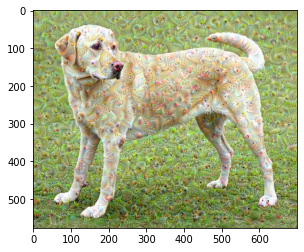

In [16]:
plt.imshow(dream_img)

Nous pouvons aussi observer le gradient cumulatif qui a été appliqué à l'image...

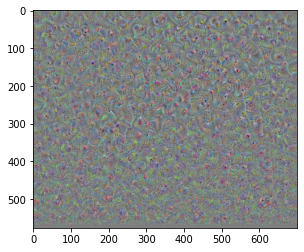

In [17]:
plt.imshow(grad_img)

Si nous soustrayons l'image-gradient de l'image deepdream, nous arrivons à l'image originale.

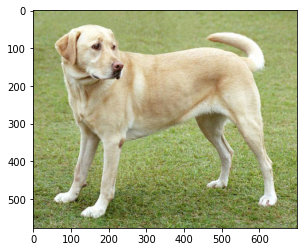

In [18]:
# 'og_image' a été créé dans la boucle principale en soustrayons l'image gradient
# de l'image deepdream avant que l'étape de *deprocess* et la conversation en
# tableau numpy (numpy array) aie eu lieu.
plt.imshow(og_image);